# Citations:

In [1]:
# @Misc{devos2015,
  #author = {Nelis J. de Vos},
  # title = {kmodes categorical clustering library},
  # howpublished = {\url{https://github.com/nicodv/kmodes}},
  # year = {2015--2021}
# }

# Importing libraries

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.utils import resample

# Data Reading and Exploration

In [3]:
fen_df = pd.read_csv('Updated.csv')
fen_df.shape

(72236, 33)

In [4]:
#Replacing NaN values in categorical columns with 'Unknown' and numerical columns with '0'
#https://saturncloud.io/blog/how-to-replace-nan-values-with-the-average-of-columns-in-pandas-dataframe/
for col in fen_df.select_dtypes(include=np.number).columns:
    fen_df[col].fillna(0, inplace=True)

for col in fen_df.select_dtypes(exclude=np.number).columns:
    fen_df[col].fillna('Unknown', inplace=True)

In [5]:
#See if there's any remaining Nan values
fen_df.isnull().sum().sum()

0

In [6]:
#Dropping Age code because they are all 1. Dropping Year because they are all 2021
fen_df = fen_df.drop(['AgeCode', 'Year'], axis=1)

In [7]:
col_999 = fen_df.loc[fen_df['Age'] == 999, ['Race', 'Education', 'Death']]
print(col_999)

          Race Education                        Death
2798     White   Unknown    Accidental Drug Poisoning
4499     White   Unknown    Accidental Drug Poisoning
5040     White   Unknown    Accidental Drug Poisoning
5988     White   Unknown    Accidental Drug Poisoning
7749   Chinese   Unknown    Accidental Drug Poisoning
9551     White   Unknown    Accidental Drug Poisoning
9576     White   Unknown    Accidental Drug Poisoning
18021    White   Unknown    Accidental Drug Poisoning
21274    White   Unknown    Accidental Drug Poisoning
21888    White   Unknown    Accidental Drug Poisoning
32896    White   Unknown  Undetermined Drug Poisoning
45222    White   Unknown    Accidental Drug Poisoning
53320    White   Unknown       Suicide Drug Poisoning


In [8]:
#Remove Age 999 as most of their information was unknown
fen_df = fen_df[fen_df['Age'] <= 150]

In [9]:
#Checking the highest age in the dataframe
fen_df['Age'].max()

98

In [10]:
#Describing the columns
columns = fen_df.columns
for c in columns:
    print('****', c, '****')
    print(fen_df[c].describe())

**** Education ****
count                                     72223
unique                                        9
top       High school graduate or GED completed
freq                                      37015
Name: Education, dtype: object
**** Month of Death ****
count     72223
unique       12
top       April
freq       6397
Name: Month of Death, dtype: object
**** Sex ****
count     72223
unique        2
top           M
freq      52195
Name: Sex, dtype: object
**** Age ****
count    72223.000000
mean        41.308157
std         12.977409
min          1.000000
25%         31.000000
50%         40.000000
75%         51.000000
max         98.000000
Name: Age, dtype: float64
**** AgeCategory ****
count             72223
unique               24
top       30 - 34 years
freq              10722
Name: AgeCategory, dtype: object
**** Marital Status ****
count                     72223
unique                        5
top       Never married, single
freq                      43313
Name: Mar

In [11]:
#Checking counts of each object in the Education feature
fen_df.groupby("Education").size().sort_values()

Education
Doctorate or professional degree           193
Masters degree                             564
Unknown                                   2298
8th grade or less                         2347
Bachelors degree                          3348
Associate degree                          3617
Some college credit, but no degree       10225
9 - 12th grade, no diploma               12616
High school graduate or GED completed    37015
dtype: int64

In [12]:
#Binning Race into specific categories 
fen_df.groupby("Race").size().sort_values()

Race
AIAN and NHOPI                                                     1
Black, AIAN and Asian                                              2
AIAN, Asian and White                                              2
Black, Asian and NHOPI                                             2
Black, Asian and White                                             6
Guamanian                                                          9
Black and Native Hawaiian or Other Pacific Islander (NHOPI)        9
Asian and NHOPI                                                   10
AIAN and Asian                                                    14
Asian, NHOPI and White                                            14
Black and Asian                                                   19
Japanese                                                          20
Hawaiian                                                          20
Black, AIAN and White                                             20
Samoan                       

In [13]:
#Group all mixed in 1 category and put Asians in 1 category and others in 1 category. We are using a mapping function for this task
def fixrace(race):
    mixed = ['AIAN, Asian, NHOPI and White', 'Black, AIAN, NHOPI and White', 'AIAN and NHOPI',
                 'Black, NHOPI and White', 'Black, Asian and NHOPI', 'Black, AIAN, Asian and White',
                 'Black, AIAN and Asian', 'AIAN, Asian and White', 'Black, Asian and White',
                 'Black and Native Hawaiian or Other Pacific Islander (NHOPI)', 'AIAN and Asian',
                 'Black, AIAN and White', 'Black and Asian', 'Asian and NHOPI', 'Asian, NHOPI and White',
                 'NHOPI and White', 'Black and AIAN', 'Asian and White', 'AIAN and White', 'Black and White']
    asian = ['Japanese', 'Chinese', 'Korean', 'Vietnamese', 'Asian Indian', 'Filipino', 'Other or Multiple Asian']
    other = ['Guamanian', 'Samoan', 'Hawaiian', 'Other or Multiple Pacific Islander', 'American Indian or Alaskan Native (AIAN)']

    if race in mixed:
        return 'Mixed'
    elif race in asian:
        return 'Asian'
    elif race in other:
        return 'Other/ Islanders'
    else:
        return race

In [14]:
fen_df['Race'] = fen_df['Race'].apply(fixrace)

In [15]:
fen_df.groupby("Race").size().sort_values()

Race
Asian                 525
Mixed                 987
Other/ Islanders      993
Black               14277
White               55441
dtype: int64

In [16]:
fen_df.head()

,Education,Month of Death,Sex,Age,AgeCategory,Marital Status,Manner of Death,Race,Occupation,Death,...,Condition11,Condition12,Condition13,Condition14,Condition15,Condition16,Condition17,Condition18,Condition19,Condition20
0,"Some college credit, but no degree",January,M,62,60 - 64 years,Divorced,Accident,Other/ Islanders,Management Occupations,Accidental Drug Poisoning,...,Unknown,Unknown,Unknown,Unknown,0.0,0.0,0.0,0.0,0.0,0.0
1,"9 - 12th grade, no diploma",January,M,17,15 - 19 years,"Never married, single",Accident,White,"Other, Misc (exc Housewife)",Accidental Drug Poisoning,...,Unknown,Unknown,Unknown,Unknown,0.0,0.0,0.0,0.0,0.0,0.0
2,"Some college credit, but no degree",January,M,35,35 - 39 years,"Never married, single",Accident,White,Management Occupations,Accidental Drug Poisoning,...,Unknown,Unknown,Unknown,Unknown,0.0,0.0,0.0,0.0,0.0,0.0
3,High school graduate or GED completed,January,M,30,30 - 34 years,"Never married, single",Accident,Other/ Islanders,"Farming, Fishing, & Forestry Occupations",Accidental Drug Poisoning,...,Unknown,Unknown,Unknown,Unknown,0.0,0.0,0.0,0.0,0.0,0.0
4,8th grade or less,January,M,68,65 - 69 years,Divorced,Accident,White,Management Occupations,Accidental Drug Poisoning,...,Unknown,Unknown,Unknown,Unknown,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#Using cut to bin ages into specific categories. Lets drop age category and make a new one with binned ages.
#https://pbpython.com/pandas-qcut-cut.html

fen_df['Age'].describe()

age_labels = ['18 and under', '19 to 30', '31 to 40', '41 to 50', '51 to 65', '65 and up']

age_bins = [0, 18, 30, 40, 50, 65, 100]

fen_df['AgeCategory'] = pd.cut(fen_df['Age'], bins=age_bins, labels=age_labels, right=True)

In [21]:
fen_df.head()

,Education,Month of Death,Sex,Age,AgeCategory,Marital Status,Manner of Death,Race,Occupation,Death,...,Condition11,Condition12,Condition13,Condition14,Condition15,Condition16,Condition17,Condition18,Condition19,Condition20
0,"Some college credit, but no degree",January,M,62,51 to 65,Divorced,Accident,Other/ Islanders,Management Occupations,Accidental Drug Poisoning,...,Unknown,Unknown,Unknown,Unknown,0.0,0.0,0.0,0.0,0.0,0.0
1,"9 - 12th grade, no diploma",January,M,17,18 and under,"Never married, single",Accident,White,"Other, Misc (exc Housewife)",Accidental Drug Poisoning,...,Unknown,Unknown,Unknown,Unknown,0.0,0.0,0.0,0.0,0.0,0.0
2,"Some college credit, but no degree",January,M,35,31 to 40,"Never married, single",Accident,White,Management Occupations,Accidental Drug Poisoning,...,Unknown,Unknown,Unknown,Unknown,0.0,0.0,0.0,0.0,0.0,0.0
3,High school graduate or GED completed,January,M,30,19 to 30,"Never married, single",Accident,Other/ Islanders,"Farming, Fishing, & Forestry Occupations",Accidental Drug Poisoning,...,Unknown,Unknown,Unknown,Unknown,0.0,0.0,0.0,0.0,0.0,0.0
4,8th grade or less,January,M,68,65 and up,Divorced,Accident,White,Management Occupations,Accidental Drug Poisoning,...,Unknown,Unknown,Unknown,Unknown,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Changing Undetermined/ Suicide/ Unknown Deaths into 1 type: Other

fen_df['Death'] = fen_df['Death'].replace(['Undetermined Drug Poisoning', 'Suicide Drug Poisoning', 'Unknown'], 'Other')

In [23]:
fen_df['Death'].value_counts()

Accidental Drug Poisoning    67848
Other                         4375
Name: Death, dtype: int64

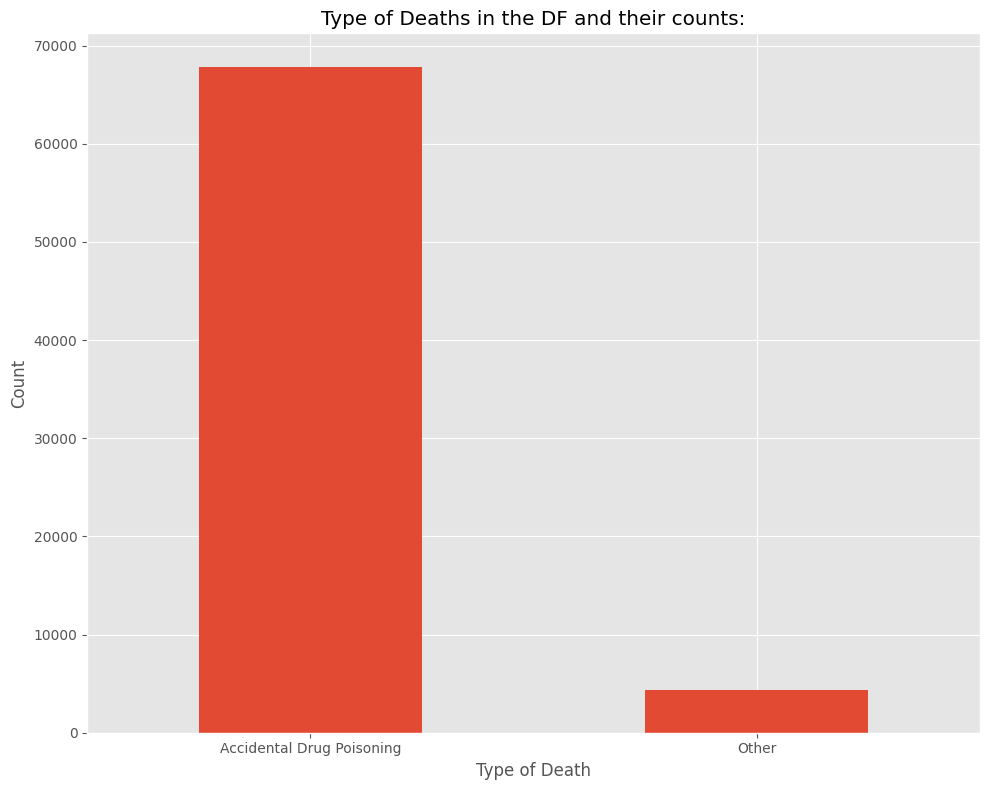

In [24]:
#Creating bar graph for the value counts for the Death column:
death_count = fen_df['Death'].value_counts()

death_count.plot(kind='bar')
plt.title('Type of Deaths in the DF and their counts:')
plt.xlabel('Type of Death')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.tight_layout()
#plt.savefig('TypesofDeathsAccidentalandother.png')

plt.show()

In [25]:
education_count = fen_df['Education'].value_counts()
height = education_count.values
bars = ('H.S. Diploma/GED', '9th-12th No Diploma', 'Some College', 'Associate Degree', 'Bachelors Degree', 
        '8th grade or less', 'Unknown', 'Masters Degree', 'PHD')

print(height)

[37015 12616 10225  3617  3348  2347  2298   564   193]


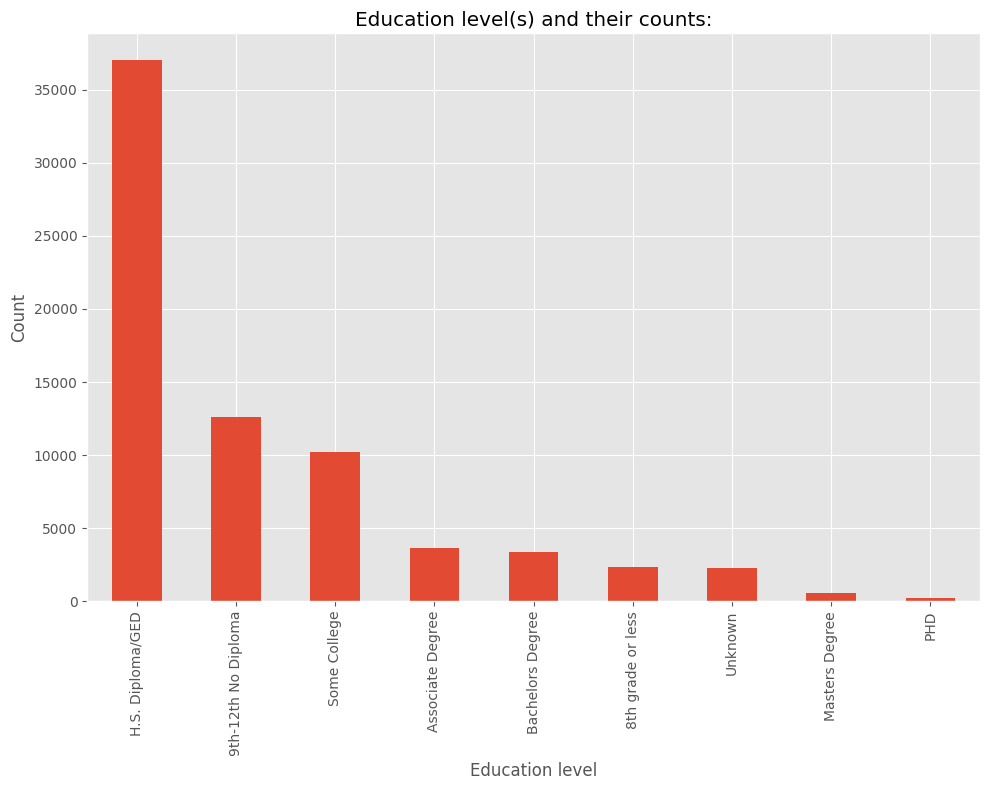

In [26]:
education_count.plot(kind='bar')
plt.title('Education level(s) and their counts:')
plt.xlabel('Education level')
plt.xticks(ticks = np.arange(len(height)), labels=bars)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# K-Mode clusting (Parameter tuning)

In [27]:
fen_df_mode = fen_df
col_to_drop = [col for col in fen_df_mode.columns if 'Condition' in col]

fen_df_mode = fen_df_mode.drop(columns=col_to_drop)
fen_df_mode = fen_df_mode.drop(columns=['Death Recode', 'Month of Death', 'Manner of Death', 'Age'], axis=1)

fen_df_mode.head()

,Education,Sex,AgeCategory,Marital Status,Race,Occupation,Death
0,"Some college credit, but no degree",M,51 to 65,Divorced,Other/ Islanders,Management Occupations,Accidental Drug Poisoning
1,"9 - 12th grade, no diploma",M,18 and under,"Never married, single",White,"Other, Misc (exc Housewife)",Accidental Drug Poisoning
2,"Some college credit, but no degree",M,31 to 40,"Never married, single",White,Management Occupations,Accidental Drug Poisoning
3,High school graduate or GED completed,M,19 to 30,"Never married, single",Other/ Islanders,"Farming, Fishing, & Forestry Occupations",Accidental Drug Poisoning
4,8th grade or less,M,65 and up,Divorced,White,Management Occupations,Accidental Drug Poisoning


Cost for init method: Huang: 141086.0
Cost for init method: Random: 145771.0
Cost for init method: Cao: 152739.0


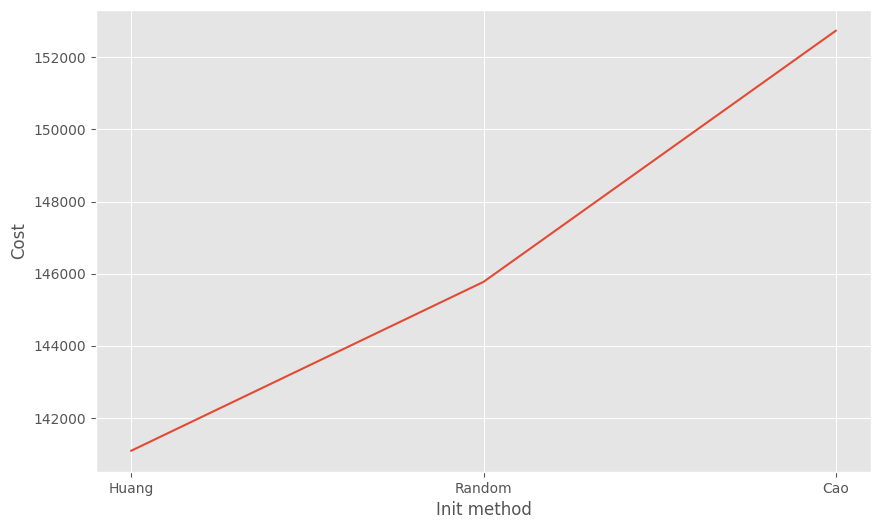

In [25]:
def find_init(data):
    init_tuning = ['Huang', 'Random', 'Cao']
    cost = []
    
    #Looping through the number of max features and finding the best
    for init in init_tuning:
        kmode = KModes(init=init, random_state=34)
        kmode.fit_predict(data)
        cost.append(kmode.cost_)
        print(f'Cost for init method: {init}: {kmode.cost_}')
    
    plt.figure(figsize=(10,6))
    plt.plot(init_tuning,cost)
    plt.xlabel('Init method')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()

find_init(fen_df_mode)

Cost for ninit method: 4: 148707.0
Cost for ninit method: 8: 147845.0
Cost for ninit method: 12: 141086.0
Cost for ninit method: 16: 141086.0
Cost for ninit method: 20: 141086.0


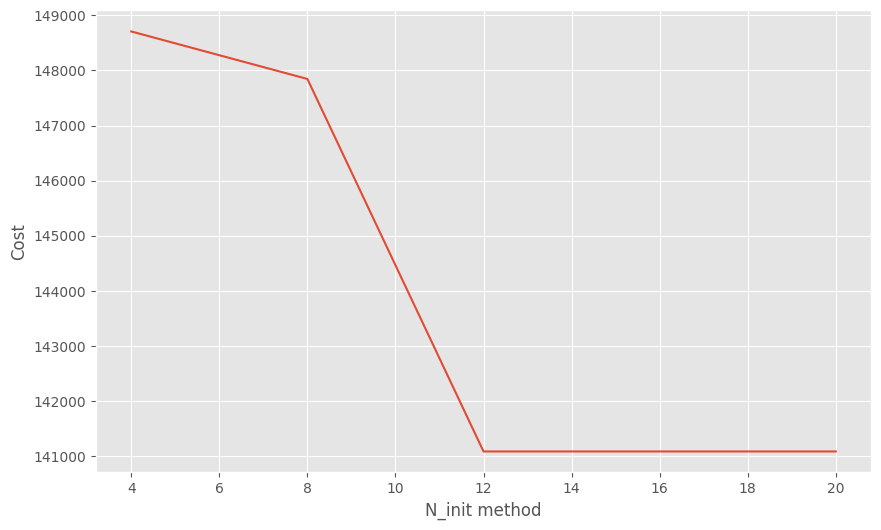

In [26]:
def find_ninit(data):
    ninit_tuning = [4, 8, 12, 16, 20]
    cost = []
    
    #Looping through the number of max features and finding the best
    for ninit in ninit_tuning:
        kmode = KModes(init='Huang', n_init=ninit, random_state=34)
        kmode.fit_predict(data)
        cost.append(kmode.cost_)
        print(f'Cost for ninit method: {ninit}: {kmode.cost_}')
    
    plt.figure(figsize=(10,6))
    plt.plot(ninit_tuning,cost)
    plt.xlabel('N_init method')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()

find_ninit(fen_df_mode)

Cost for Max iterations: 100: 141086.0
Cost for Max iterations: 200: 141086.0
Cost for Max iterations: 300: 141086.0


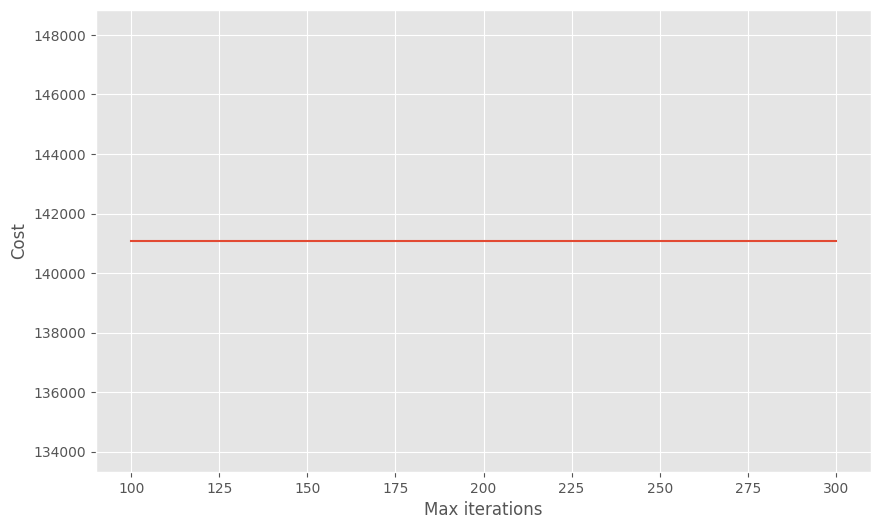

In [27]:
def find_max(data):
    max_tuning= [100, 200, 300]
    cost = []
    
    #Looping through the number of max features and finding the best
    for max in max_tuning:
        kmode = KModes(init='Huang', n_init=12, max_iter=max, random_state=34)
        kmode.fit_predict(data)
        cost.append(kmode.cost_)
        print(f'Cost for Max iterations: {max}: {kmode.cost_}')
    
    plt.figure(figsize=(10,6))
    plt.plot(max_tuning,cost)
    plt.xlabel('Max iterations')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()

find_max(fen_df_mode)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, ite

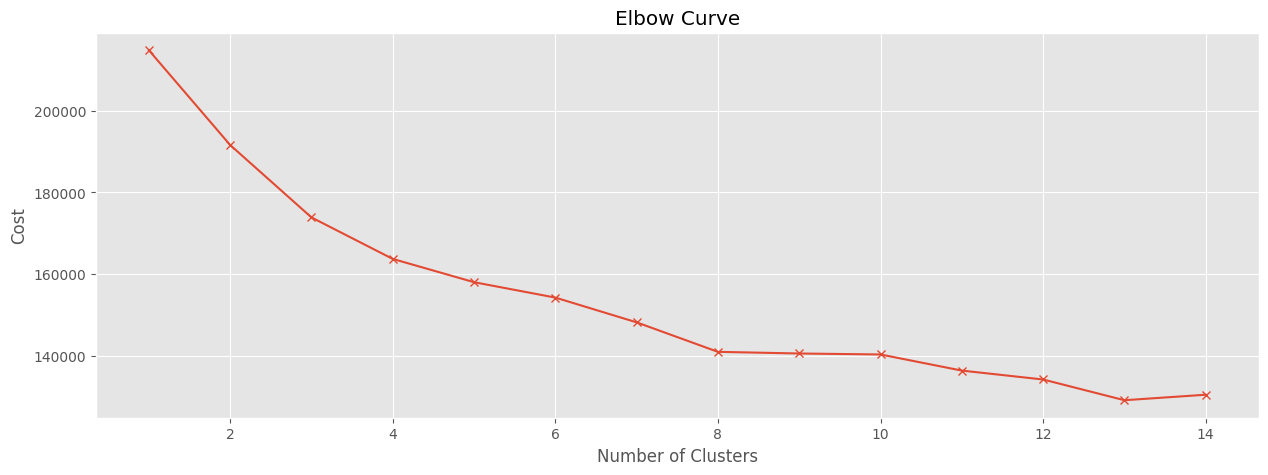

Elbow is at k = 4.000000 clusters


In [57]:
#Elbow method to find the number of clusters or k we are going to implement. Use KneeLocator to get the K value. 
#Detects elbows if curve is convex. We use the tuned parameters from above.

def find_num_clusters(data, k):
    iters = range(1,k)
    
    cost = [] 
    for i in list(iters):
        kmode = KModes(n_clusters=i, init='Huang', n_init=12, max_iter=100, random_state=34, verbose=1) 
        kmode.fit_predict(data)
        cost.append(kmode.cost_)
        print('Fit {} clusters'.format(i))

    plt.plot(iters, cost, 'x-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Cost')
    plt.title('Elbow Curve')
    plt.show()

    #Get the K value. Detects elbows if curve is convex.
    knee = KneeLocator(x=iters, y=cost, S=0.1, curve='convex', direction='decreasing')
    K_knee = knee.elbow
    print('Elbow is at k =', f'{K_knee:0f} clusters')
    
find_num_clusters(fen_df_mode, 15)

# K mode clustering without the Death Column: 

In [28]:
fen_df_mode

,Education,Sex,AgeCategory,Marital Status,Race,Occupation,Death
0,"Some college credit, but no degree",M,51 to 65,Divorced,Other/ Islanders,Management Occupations,Accidental Drug Poisoning
1,"9 - 12th grade, no diploma",M,18 and under,"Never married, single",White,"Other, Misc (exc Housewife)",Accidental Drug Poisoning
2,"Some college credit, but no degree",M,31 to 40,"Never married, single",White,Management Occupations,Accidental Drug Poisoning
3,High school graduate or GED completed,M,19 to 30,"Never married, single",Other/ Islanders,"Farming, Fishing, & Forestry Occupations",Accidental Drug Poisoning
4,8th grade or less,M,65 and up,Divorced,White,Management Occupations,Accidental Drug Poisoning
...,...,...,...,...,...,...,...
72231,8th grade or less,M,41 to 50,Marital Status unknown,White,Construction & Extraction Occupations,Accidental Drug Poisoning
72232,High school graduate or GED completed,F,51 to 65,Divorced,White,"Other, Housewife",Accidental Drug Poisoning
72233,High school graduate or GED completed,M,41 to 50,Divorced,Black,Transportation & Material Moving Occupations,Accidental Drug Poisoning
72234,High school graduate or GED completed,M,51 to 65,"Never married, single",White,"Other, Misc (exc Housewife)",Accidental Drug Poisoning


In [29]:
cost=[] #For testing 
k=4
kmode= KModes(n_clusters=k, init='Huang', n_init=12, max_iter=100, random_state=34)
clusters=kmode.fit_predict(fen_df_mode[['Education','Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation']])
cost.append(kmode.cost_)
print(cost)

clusters_dict = []

for c in clusters:
    clusters_dict.append(c)

fen_df_mode['Clusters'] = clusters_dict

[161943.0]


In [30]:
print(kmode.cluster_centroids_)

[['High school graduate or GED completed' 'M' '31 to 40'
  'Never married, single' 'White'
  'Food Preparation & Serving Related Occupations']
 ['9 - 12th grade, no diploma' 'M' '41 to 50' 'Married' 'White'
  'Other, Misc (exc Housewife)']
 ['High school graduate or GED completed' 'M' '51 to 65' 'Divorced'
  'White' 'Construction & Extraction Occupations']
 ['High school graduate or GED completed' 'M' '19 to 30'
  'Never married, single' 'White' 'Other, Misc (exc Housewife)']]


In [31]:
fen_df_mode['Clusters'].value_counts()

0    32040
3    15029
2    12899
1    12255
Name: Clusters, dtype: int64

In [32]:
#Adding 1 to cluster for clarity on the paper. The Clusters are going to change from 0, 1, 2, 3 to 1, 2, 3, 4.
fen_df_mode['Clusters'] = fen_df_mode['Clusters'] + 1

In [33]:
fen_df_mode['Clusters'].value_counts()

1    32040
4    15029
3    12899
2    12255
Name: Clusters, dtype: int64

In [34]:
fen_df_mode.head()

,Education,Sex,AgeCategory,Marital Status,Race,Occupation,Death,Clusters
0,"Some college credit, but no degree",M,51 to 65,Divorced,Other/ Islanders,Management Occupations,Accidental Drug Poisoning,3
1,"9 - 12th grade, no diploma",M,18 and under,"Never married, single",White,"Other, Misc (exc Housewife)",Accidental Drug Poisoning,2
2,"Some college credit, but no degree",M,31 to 40,"Never married, single",White,Management Occupations,Accidental Drug Poisoning,1
3,High school graduate or GED completed,M,19 to 30,"Never married, single",Other/ Islanders,"Farming, Fishing, & Forestry Occupations",Accidental Drug Poisoning,4
4,8th grade or less,M,65 and up,Divorced,White,Management Occupations,Accidental Drug Poisoning,3


In [35]:
#Aggfuns specifies we are counting.
frequency_edu = fen_df_mode.pivot_table(index='Clusters', columns='Education', aggfunc='size')

frequency_edu

Education,8th grade or less,"9 - 12th grade, no diploma",Associate degree,Bachelors degree,Doctorate or professional degree,High school graduate or GED completed,Masters degree,"Some college credit, but no degree",Unknown
Clusters,,,,,,,,,
1,1092,4110,1759,1690,76,17712,283,4835,483
2,507,5034,789,696,66,1981,142,1768,1272
3,376,1210,551,466,31,8601,99,1367,198
4,372,2262,518,496,20,8721,40,2255,345


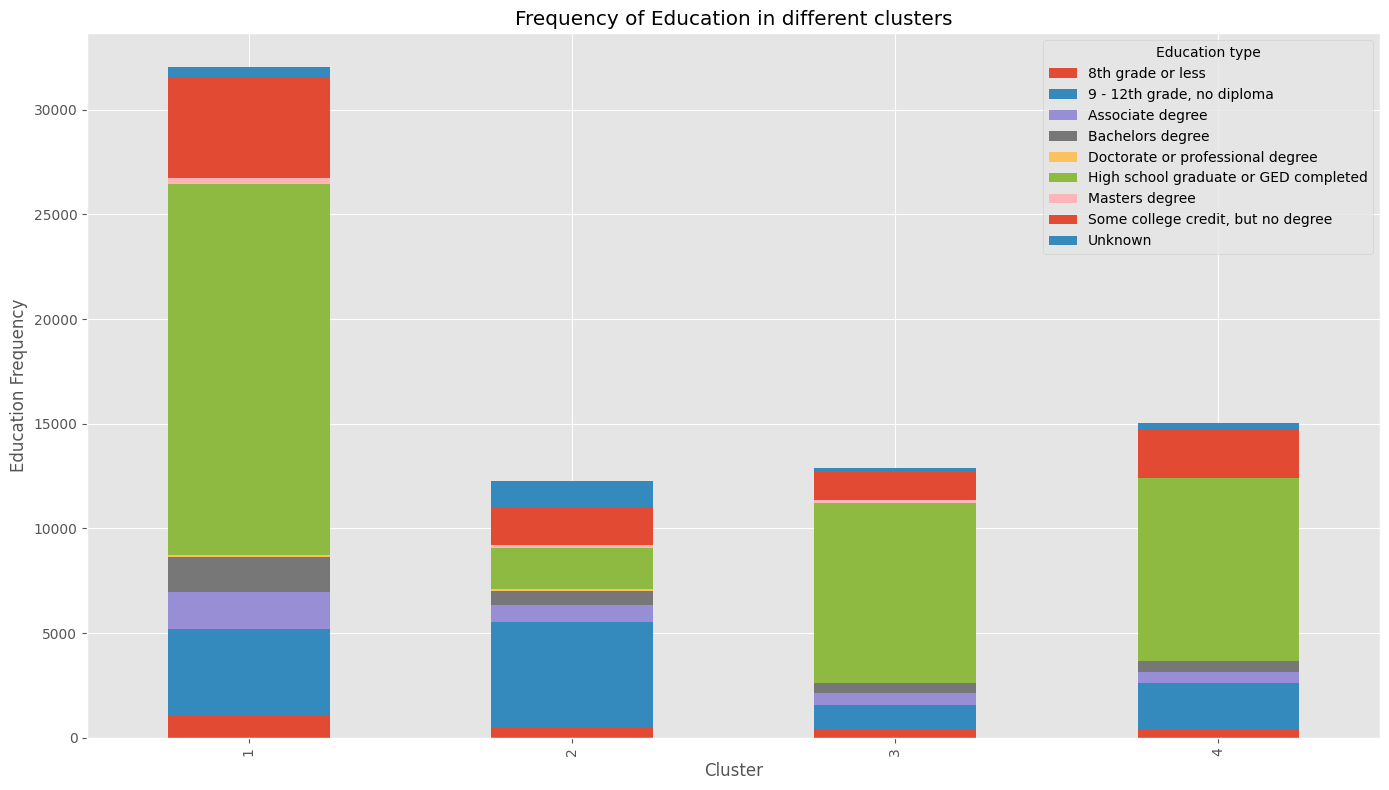

In [36]:
frequency_edu.plot(kind='bar', figsize=(14, 8), stacked=True)
plt.title('Frequency of Education in different clusters')
plt.ylabel('Education Frequency')
plt.xlabel('Cluster')
plt.legend(title='Education type') 
plt.tight_layout() 
plt.show()

In [37]:
#Aggfuns specifies we are counting.
frequency_death = fen_df_mode.pivot_table(index='Clusters', columns='Death', aggfunc='size')

frequency_death

Death,Accidental Drug Poisoning,Other
Clusters,,
1,30070,1970
2,11473,782
3,12064,835
4,14241,788


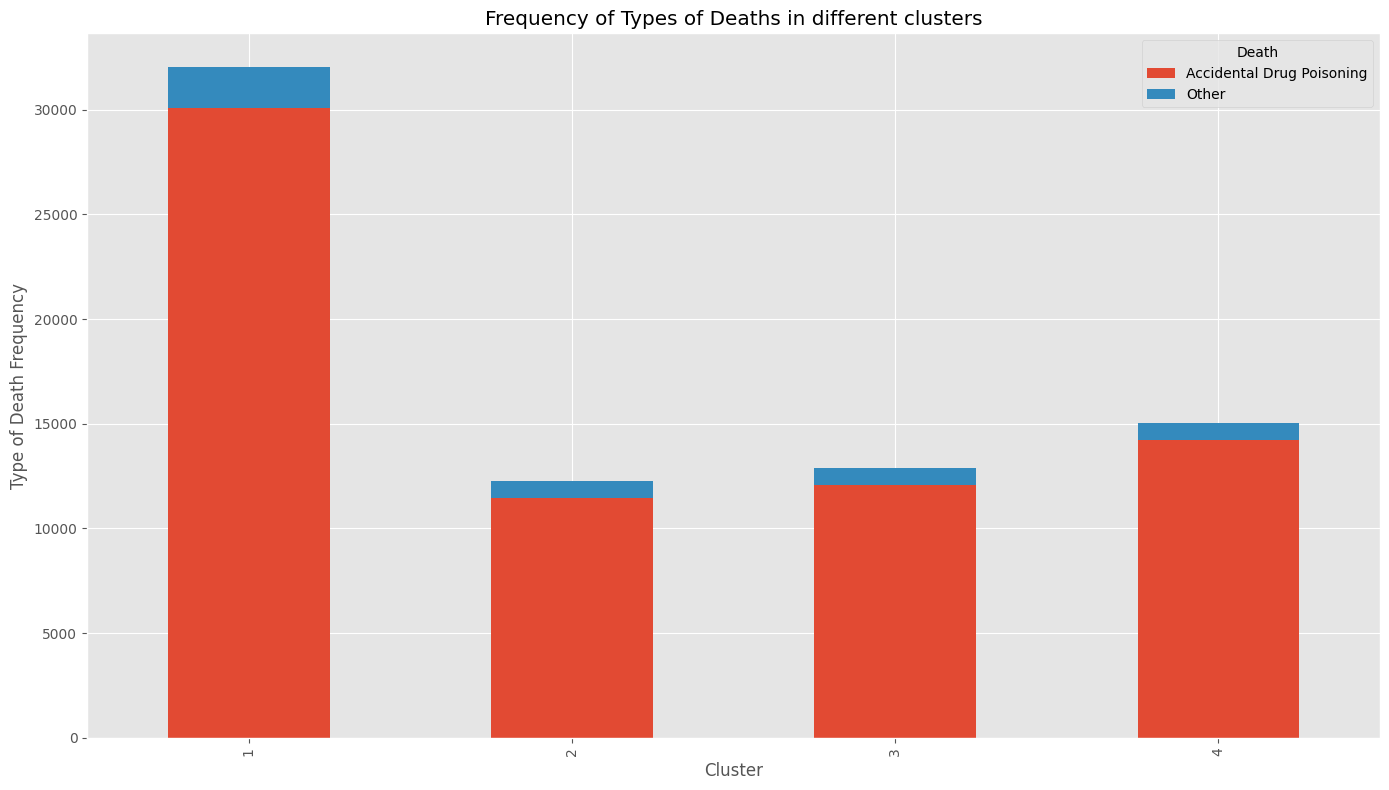

In [38]:
frequency_death.plot(kind='bar', figsize=(14, 8), stacked=True)
plt.title('Frequency of Types of Deaths in different clusters')
plt.ylabel('Type of Death Frequency')
plt.xlabel('Cluster')
plt.legend(title='Death') 
plt.tight_layout() #optimizes the spacing of everything
plt.show()

In [39]:
#Pivot tables allow you to perform calculations such as sums, averages, and standard deviations, while Crosstab does not.
heat_edu = fen_df_mode.pivot_table(index='Age', columns='Clusters', aggfunc='size')
heat_edu

Clusters,1,2,3,4
Education,,,,
8th grade or less,1092,507,376,372
"9 - 12th grade, no diploma",4110,5034,1210,2262
Associate degree,1759,789,551,518
Bachelors degree,1690,696,466,496
Doctorate or professional degree,76,66,31,20
High school graduate or GED completed,17712,1981,8601,8721
Masters degree,283,142,99,40
"Some college credit, but no degree",4835,1768,1367,2255
Unknown,483,1272,198,345


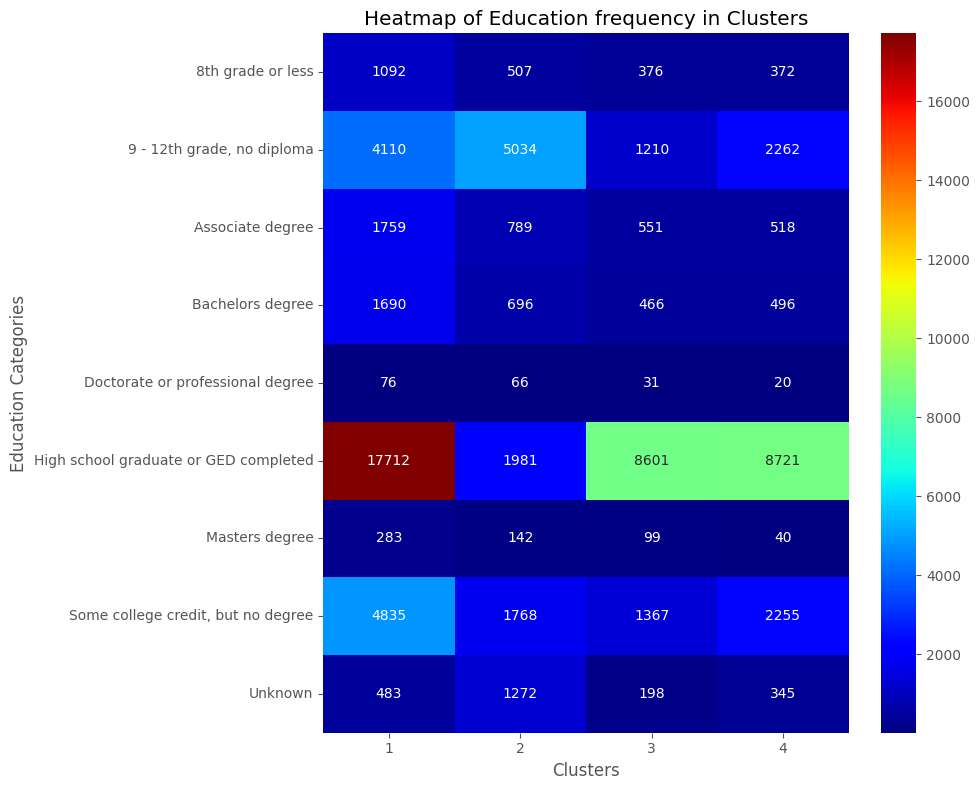

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(heat_edu, annot=True, fmt="d", cmap="jet") 
plt.title('Heatmap of Education frequency in Clusters')
plt.ylabel('Education Categories')
plt.xlabel('Clusters')
plt.tight_layout()
#plt.savefig('edu_without_death.png')
plt.show()

# Splitting DataFrame based on clusters

In [41]:
cluster_1 = fen_df_mode[fen_df_mode['Clusters'] == 1]

In [42]:
cluster_2 = fen_df_mode[fen_df_mode['Clusters'] == 2]

In [43]:
cluster_3 = fen_df_mode[fen_df_mode['Clusters'] == 3]

In [44]:
cluster_4 = fen_df_mode[fen_df_mode['Clusters'] == 4]

In [45]:
clusters = [cluster_1, cluster_2, cluster_3, cluster_4]

for c in clusters:
    print(c['Death'].value_counts())
    c.reset_index(drop=True, inplace=True)

Accidental Drug Poisoning    30070
Other                         1970
Name: Death, dtype: int64
Accidental Drug Poisoning    11473
Other                          782
Name: Death, dtype: int64
Accidental Drug Poisoning    12064
Other                          835
Name: Death, dtype: int64
Accidental Drug Poisoning    14241
Other                          788
Name: Death, dtype: int64


# Cluster 1: XGBoost/ Oversample 20%/ Tuned

In [46]:
cluster_1 = cluster_1.drop('Clusters', axis=1)
cluster_1.head()

,Education,Sex,AgeCategory,Marital Status,Race,Occupation,Death
0,"Some college credit, but no degree",M,31 to 40,"Never married, single",White,Management Occupations,Accidental Drug Poisoning
1,High school graduate or GED completed,M,31 to 40,"Never married, single",Other/ Islanders,Food Preparation & Serving Related Occupations,Accidental Drug Poisoning
2,Unknown,M,31 to 40,"Never married, single",Other/ Islanders,Construction & Extraction Occupations,Accidental Drug Poisoning
3,"9 - 12th grade, no diploma",F,31 to 40,Divorced,Other/ Islanders,"Other, Housewife",Accidental Drug Poisoning
4,High school graduate or GED completed,F,19 to 30,"Never married, single",White,Food Preparation & Serving Related Occupations,Accidental Drug Poisoning


In [47]:
cluster_1 = pd.get_dummies(cluster_1, 
                           columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], 
                           prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_1.head()

,dummy_edu_8th grade or less,"dummy_edu_9 - 12th grade, no diploma",dummy_edu_Associate degree,dummy_edu_Bachelors degree,dummy_edu_Doctorate or professional degree,dummy_edu_High school graduate or GED completed,dummy_edu_Masters degree,"dummy_edu_Some college credit, but no degree",dummy_edu_Unknown,dummy_sex_F,...,"dummy_occupation_Other, Housewife","dummy_occupation_Other, Misc (exc Housewife)",dummy_occupation_Personal Care & Service Occupations,dummy_occupation_Production Occupations,dummy_occupation_Protective Service Occupations,dummy_occupation_Sales & Related Occupations,dummy_occupation_Transportation & Material Moving Occupations,dummy_occupation_Unknown,dummy_death_Accidental Drug Poisoning,dummy_death_Other
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [48]:
# Sex attribute has two values only so we can drop one of them since they are considered redundant.
#We are predicting Accidental or not, so only 1 column is sufficient. 
cluster_1.drop('dummy_death_Other', axis=1, inplace=True)
cluster_1.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_1.drop('dummy_sex_F', axis=1, inplace=True)
#1 = Accidental, 0 = Other

In [49]:
clus1_train, clus1_test = train_test_split(cluster_1, test_size=0.25, random_state=34)
print(clus1_train.shape)
print(clus1_test.shape)

(24030, 53)
(8010, 53)


In [50]:
print(clus1_train["Death"].count())
print(clus1_train["Death"].value_counts(normalize = True))
clus1_train["Death"].value_counts()

24030
1    0.937703
0    0.062297
Name: Death, dtype: float64


1    22533
0     1497
Name: Death, dtype: int64

In [51]:
def determine_samples(records, unique_records, proportion):
    samples = int((proportion * records - unique_records) / (1 - proportion))
    return samples

In [52]:
num_samples_other_deaths_1 = determine_samples(len(clus1_train), 1497, 0.2)
print("Other Deaths oversample samples to add in Cluster 1: ", num_samples_other_deaths_1)

Other Deaths oversample samples to add in Cluster 1:  4136


In [53]:
to_resample_1 = clus1_train.loc[clus1_train['Death'] == 0]

In [54]:
our_resample_1 = to_resample_1.sample(n = 4136 , replace = True)
clus1_train_rebal = pd.concat([clus1_train, our_resample_1])

In [55]:
clus1_train_rebal['Death'].value_counts()

1    22533
0     5633
Name: Death, dtype: int64

In [56]:
x_train1 = clus1_train_rebal.drop('Death', axis=1)
y_train1 = clus1_train_rebal['Death']

In [57]:
x_test1 = clus1_test.drop('Death', axis=1)
y_test1 = clus1_test['Death']

In [58]:
kfold = KFold(n_splits= 10, shuffle=True, random_state=34)

In [59]:
y_train1.value_counts()

#Since 'Accidental Drug Poisoning' is the most occurring value for this target attribute we will use that as the prediction value for any records. 
#If we use this on our training set we would correctly classify 22533 records and miss-classify 5633 records. 
#This gives us an accuracy around 80%.

1    22533
0     5633
Name: Death, dtype: int64

In [60]:
print(f'Our baseline model for Cluster 1 is {y_train1.value_counts(normalize = True)[1] * 100}% accurate')
print(f'Our baseline model for Cluster 1 based on the testing set is {y_test1.value_counts(normalize = True)[1] * 100}% accurate')

Our baseline model for Cluster 1 is 80.00071007597813% accurate
Our baseline model for Cluster 1 based on the testing set is 94.09488139825218% accurate


In [61]:
#Using CrossValidation for model selection: 
clus1_models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
                     'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
                     'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
                     'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

clus1_model_cv_score = {}

for name, model in clus1_models_dict.items():
    score1 = cross_val_score(model, x_train1, y_train1, cv=kfold)
    clus1_model_cv_score[name] = score1.mean()

print(f'Model Scores: {clus1_model_cv_score}')

Model Scores: {'RandomForest': 0.8230134814599671, 'NaiveBayes': 0.7995810743214896, 'XGBoost': 0.8093803323772871, 'Decision Tree': 0.8091317528318326}


In [57]:
#Parameter tuning:
clus1_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5, 7]
}

grid1 = GridSearchCV(XGBClassifier(), param_grid = clus1_params, cv = kfold, n_jobs = -1, verbose = 1)
grid1.fit(x_train1, y_train1)

print("Best Parameters found for Cluster 1: ", grid1.best_params_)
print("Best Accuracy through grid search for Cluster 1: %.3f"%grid1.best_score_)

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits
Best Parameters found for Cluster 1:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}
Best Accuracy through grid search for Cluster 1: 0.825


In [62]:
xgb1 = XGBClassifier(colsample_bytree = 0.8, learning_rate = 0.1, max_depth = 9, min_child_weight = 1, 
                     n_estimators = 500, subsample = 0.8, random_state=34).fit(x_train1, y_train1)

xgb1_score = cross_val_score(xgb1, x_train1, y_train1, cv=kfold)

In [63]:
print(f"Our XGBoost with the best optimized parameters on the Testing set for Cluster 1 is: {xgb1.score(x_test1, y_test1) * 100}% accurate")
print(f"Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 1 is: {xgb1_score.mean() * 100}% accurate")

Our XGBoost with the best optimized parameters on the Testing set for Cluster 1 is: 92.55930087390762% accurate
Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 1 is: 82.20551914915933% accurate


In [64]:
prediction_xgb1 = xgb1.predict(x_test1)

print("Classification Report for Cluster 1:")
print(classification_report(y_test1, prediction_xgb1))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test1, prediction_xgb1))
print("============")
print("Accuracy Score: ", accuracy_score(prediction_xgb1, y_test1))
print("==============")

test1_predictions_proba = xgb1.predict_proba(x_test1)
log_1 = log_loss(y_test1, test1_predictions_proba)
print("Log Loss: {:.4}".format(log_1))
print("===============")

Classification Report for Cluster 1:
              precision    recall  f1-score   support

           0       0.18      0.07      0.10       473
           1       0.94      0.98      0.96      7537

    accuracy                           0.93      8010
   macro avg       0.56      0.53      0.53      8010
weighted avg       0.90      0.93      0.91      8010

Confusion Matrix
[[  34  439]
 [ 157 7380]]
Accuracy Score:  0.9255930087390761
Log Loss: 0.313


In [72]:
def plot_confusion_matrix(Y_test, Y_preds):
    conf_mat = confusion_matrix(Y_test, Y_preds)
    fig = plt.figure(figsize=(6,6))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.yticks(range(2), range(2))
    plt.xticks(range(2), range(2))
    plt.colorbar();
    for i in range(2):
        for j in range(2):
            plt.text(i-0.1,j, str(conf_mat[j, i]), color='tab:red')

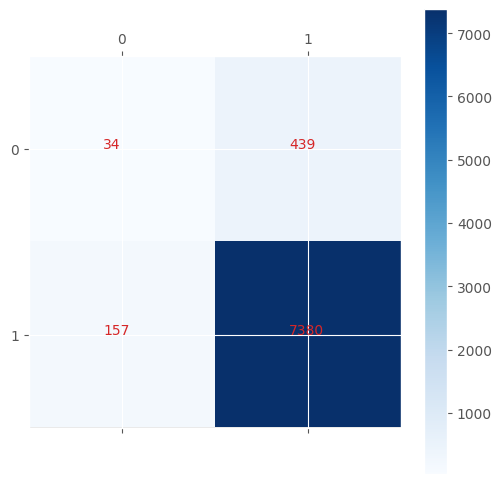

In [73]:
#Visualization for our XGBoost model confusion matrix 
plot_confusion_matrix(y_test1, prediction_xgb1)

In [74]:
def feature_importance(x, y, cluster):
    plt.figure(figsize = (16 , 9))
    sns.barplot(x = x.columns, y = y)
    plt.xlabel("Features")
    plt.xticks(rotation=90)
    plt.ylabel("% of Decisions")
    plt.title(f"Feature Importances for Cluster {cluster}")
    plt.tight_layout()
    plt.show()

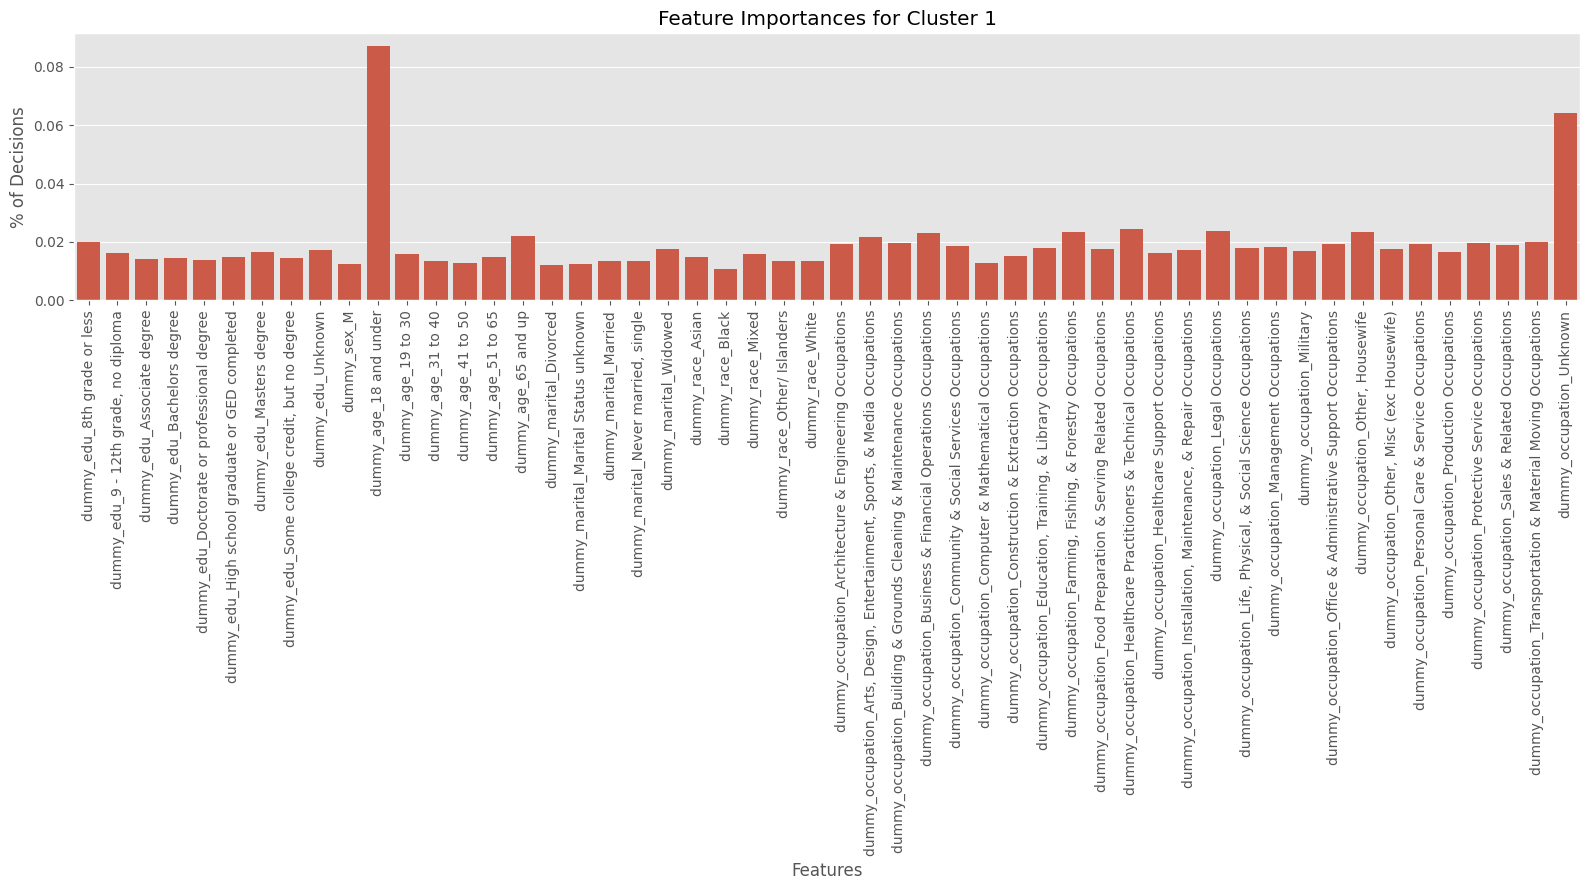

In [75]:
clus1_features = xgb1.feature_importances_

feature_importance(x_train1, clus1_features, 1)

In [76]:
#Tablular format of feature importances and the features being used to make decions for our XGBoost decision tree model
clus1_feature_importances_table = pd.DataFrame(data = {"Features": x_train1.columns, "Data": clus1_features})
clus1_feature_importances_table[clus1_feature_importances_table["Data"] > 0]

,Features,Data
0,dummy_edu_8th grade or less,0.020088
1,"dummy_edu_9 - 12th grade, no diploma",0.016357
2,dummy_edu_Associate degree,0.014238
3,dummy_edu_Bachelors degree,0.014473
4,dummy_edu_Doctorate or professional degree,0.013771
5,dummy_edu_High school graduate or GED completed,0.014733
6,dummy_edu_Masters degree,0.016461
7,"dummy_edu_Some college credit, but no degree",0.014417
8,dummy_edu_Unknown,0.017094
9,dummy_sex_M,0.012513


In [77]:
clus1_top_5 = clus1_feature_importances_table.sort_values(by='Data', ascending=False).head(5)
clus1_top_5

,Features,Data
10,dummy_age_18 and under,0.087159
51,dummy_occupation_Unknown,0.064253
36,dummy_occupation_Healthcare Practitioners & Te...,0.024527
39,dummy_occupation_Legal Occupations,0.023655
34,"dummy_occupation_Farming, Fishing, & Forestry ...",0.023457


# Cluster 2: XGBoost/ Oversample 20%/ Tuned

In [78]:
cluster_2 = cluster_2.drop('Clusters', axis=1)
cluster_2.head()

,Education,Sex,AgeCategory,Marital Status,Race,Occupation,Death
0,"9 - 12th grade, no diploma",M,18 and under,"Never married, single",White,"Other, Misc (exc Housewife)",Accidental Drug Poisoning
1,Unknown,F,51 to 65,Married,White,"Other, Misc (exc Housewife)",Other
2,Masters degree,M,41 to 50,Divorced,White,"Education, Training, & Library Occupations",Accidental Drug Poisoning
3,"Some college credit, but no degree",F,31 to 40,Married,Other/ Islanders,"Other, Misc (exc Housewife)",Accidental Drug Poisoning
4,"9 - 12th grade, no diploma",F,31 to 40,Married,Mixed,"Other, Misc (exc Housewife)",Accidental Drug Poisoning


In [79]:
cluster_2 = pd.get_dummies(cluster_2, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_2.head()

,dummy_edu_8th grade or less,"dummy_edu_9 - 12th grade, no diploma",dummy_edu_Associate degree,dummy_edu_Bachelors degree,dummy_edu_Doctorate or professional degree,dummy_edu_High school graduate or GED completed,dummy_edu_Masters degree,"dummy_edu_Some college credit, but no degree",dummy_edu_Unknown,dummy_sex_F,...,"dummy_occupation_Other, Housewife","dummy_occupation_Other, Misc (exc Housewife)",dummy_occupation_Personal Care & Service Occupations,dummy_occupation_Production Occupations,dummy_occupation_Protective Service Occupations,dummy_occupation_Sales & Related Occupations,dummy_occupation_Transportation & Material Moving Occupations,dummy_occupation_Unknown,dummy_death_Accidental Drug Poisoning,dummy_death_Other
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


In [80]:
# Death and Sex attribute has two values only so we can drop one of them since they are considered redundant. 
#We are predicting Accidental or not, so only 1 column is sufficient. 

cluster_2.drop('dummy_death_Other', axis=1, inplace=True)
cluster_2.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_2.drop('dummy_sex_F', axis=1, inplace=True)

#1 = Accidental, 0 = Other

In [81]:
clus2_train, clus2_test = train_test_split(cluster_2, test_size=0.25, random_state=34)
print(clus2_train.shape)
print(clus2_test.shape)

(9191, 53)
(3064, 53)


In [82]:
print(clus2_train["Death"].count())
print(clus2_train["Death"].value_counts(normalize = True))
clus2_train["Death"].value_counts()

9191
1    0.93548
0    0.06452
Name: Death, dtype: float64


1    8598
0     593
Name: Death, dtype: int64

In [83]:
num_samples_other_deaths_2 = determine_samples(len(clus2_train), 593, 0.2)
print("Other Deaths oversample samples to add in Cluster 2: ", num_samples_other_deaths_2)

Other Deaths oversample samples to add in Cluster 2:  1556


In [84]:
to_resample_2 = clus2_train.loc[clus2_train['Death'] == 0]

In [85]:
our_resample_2 = to_resample_2.sample(n = 1556 , replace = True)
clus2_train_rebal = pd.concat([clus2_train, our_resample_2])

In [86]:
clus2_train_rebal['Death'].value_counts()

1    8598
0    2149
Name: Death, dtype: int64

In [87]:
x_train2 = clus2_train_rebal.drop('Death', axis=1)
y_train2 = clus2_train_rebal['Death']

In [88]:
x_test2 = clus2_test.drop('Death', axis=1)
y_test2 = clus2_test['Death']

In [89]:
print(f'Our baseline model for Cluster 2 is {y_train2.value_counts(normalize = True)[1] * 100}% accurate')
print(f'Our baseline model for Cluster 2 based on the testing partition is {y_test2.value_counts(normalize = True)[1] * 100}% accurate')

Our baseline model for Cluster 2 is 80.00372196892155% accurate
Our baseline model for Cluster 2 based on the testing partition is 93.83159268929504% accurate


In [90]:
#Using CrossValidation for model selection: 
clus2_models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
                     'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
                     'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
                     'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

clus2_model_cv_score = {}

for name, model in clus2_models_dict.items():
    score2 = cross_val_score(model, x_train2, y_train2, cv=kfold)
    clus2_model_cv_score[name] = score2.mean()

print(f'Model Scores: {clus2_model_cv_score}')

Model Scores: {'RandomForest': 0.8302808886579186, 'NaiveBayes': 0.7996654107660994, 'XGBoost': 0.7996653241522672, 'Decision Tree': 0.8000375037893551}


In [71]:
##Parameter tuning:
clus2_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5, 7]
}

grid2 = GridSearchCV(XGBClassifier(), param_grid = clus2_params, cv = kfold, n_jobs = -1, verbose = 1)
grid2.fit(x_train2, y_train2)

print("Best Parameters found for Cluster 2: ", grid2.best_params_)
print("Best Accuracy through grid search for Cluster 2: %.3f"%grid2.best_score_)

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits
Best Parameters found for Cluster 2:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.9}
Best Accuracy through grid search for Cluster 2: 0.826


In [91]:
#BEST SCORE:
xgb2 = XGBClassifier(colsample_bytree = 0.7, learning_rate = 0.1, max_depth = 9, min_child_weight = 1, 
                     n_estimators = 500, subsample = 0.9, random_state=34).fit(x_train2, y_train2)

xgb2_score = cross_val_score(xgb2, x_train2, y_train2, cv=kfold)

In [92]:
print(f"Our XGBoost with the best optimized parameters on the Testing set for Cluster 2 is: {xgb2.score(x_test2, y_test2) * 100}% accurate")
print(f"Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 2 is: {xgb2_score.mean() * 100}% accurate")

Our XGBoost with the best optimized parameters on the Testing set for Cluster 2 is: 90.53524804177546% accurate
Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 2 is: 82.6930405785804% accurate


In [93]:
prediction_xgb2 = xgb2.predict(x_test2)

print("Classification Report for Cluster 2:")
print(classification_report(y_test2, prediction_xgb2))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test2, prediction_xgb2))
print("============")
print("Accuracy Score: ", accuracy_score(prediction_xgb2, y_test2))
print("==============")

test2_predictions_proba = xgb2.predict_proba(x_test2)
log_2 = log_loss(y_test2, test2_predictions_proba)
print("Log Loss: {:.4}".format(log_2))
print("===============")

Classification Report for Cluster 2:
              precision    recall  f1-score   support

           0       0.06      0.04      0.05       189
           1       0.94      0.96      0.95      2875

    accuracy                           0.91      3064
   macro avg       0.50      0.50      0.50      3064
weighted avg       0.88      0.91      0.89      3064

Confusion Matrix
[[   7  182]
 [ 108 2767]]
Accuracy Score:  0.9053524804177546
Log Loss: 0.3322


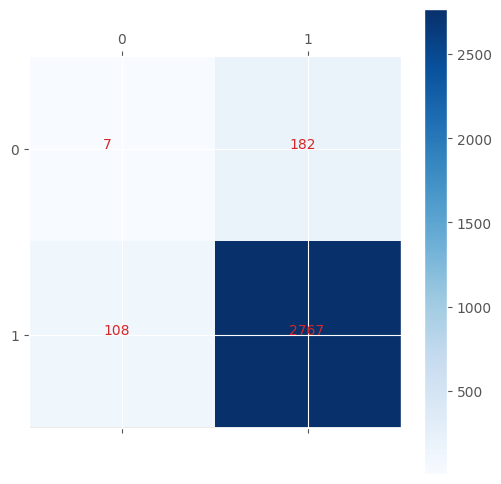

In [94]:
#Visualization for our XGBoost model confusion matrix 
plot_confusion_matrix(y_test2, prediction_xgb2)

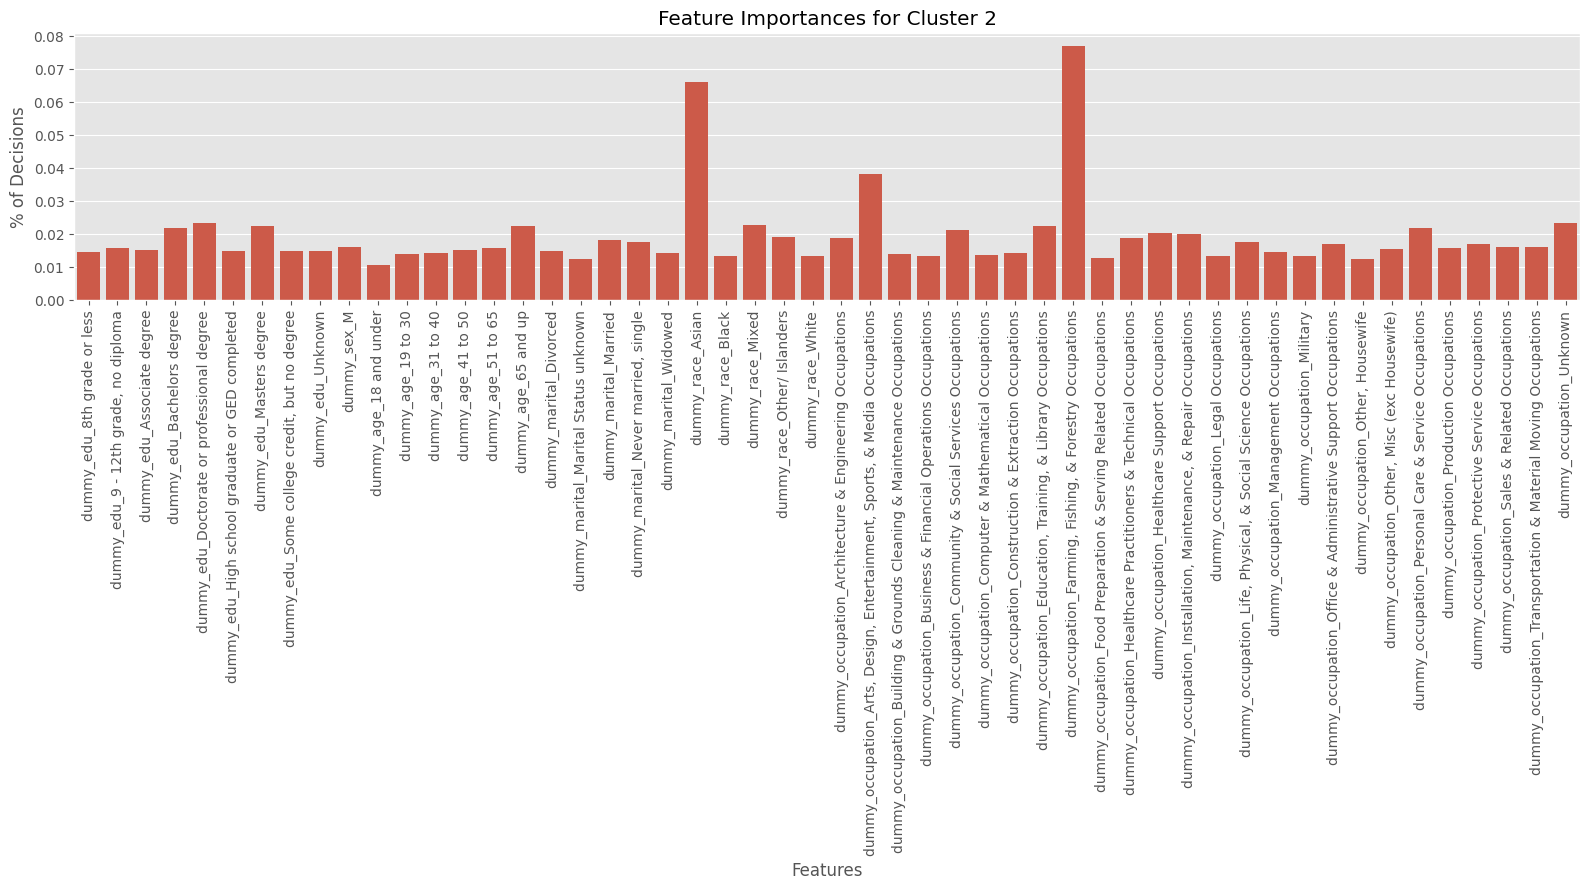

In [95]:
clus2_features = xgb2.feature_importances_
feature_importance(x_train2, clus2_features, 2)

In [96]:
#Tablular format of feature importances and the features being used to make decions for our XGBoost decision tree model
clus2_feature_importances_table = pd.DataFrame(data = {"Features": x_train2.columns, "Data": clus2_features})
clus2_feature_importances_table[clus2_feature_importances_table["Data"] > 0]

,Features,Data
0,dummy_edu_8th grade or less,0.014630
1,"dummy_edu_9 - 12th grade, no diploma",0.015841
2,dummy_edu_Associate degree,0.015157
3,dummy_edu_Bachelors degree,0.021955
4,dummy_edu_Doctorate or professional degree,0.023358
5,dummy_edu_High school graduate or GED completed,0.014990
6,dummy_edu_Masters degree,0.022599
7,"dummy_edu_Some college credit, but no degree",0.014982
8,dummy_edu_Unknown,0.014982
9,dummy_sex_M,0.016023


In [97]:
clus2_top_5 = clus2_feature_importances_table.sort_values(by='Data', ascending=False).head(5)
clus2_top_5

,Features,Data
34,"dummy_occupation_Farming, Fishing, & Forestry ...",0.077058
21,dummy_race_Asian,0.066194
27,"dummy_occupation_Arts, Design, Entertainment, ...",0.038266
51,dummy_occupation_Unknown,0.023375
4,dummy_edu_Doctorate or professional degree,0.023358


# Cluster 3: XGBoost/ Oversample 20%/ Tuned

In [98]:
cluster_3 = cluster_3.drop('Clusters', axis=1)
cluster_3.head()

,Education,Sex,AgeCategory,Marital Status,Race,Occupation,Death
0,"Some college credit, but no degree",M,51 to 65,Divorced,Other/ Islanders,Management Occupations,Accidental Drug Poisoning
1,8th grade or less,M,65 and up,Divorced,White,Management Occupations,Accidental Drug Poisoning
2,High school graduate or GED completed,M,51 to 65,Divorced,White,Office & Administrative Support Occupations,Accidental Drug Poisoning
3,High school graduate or GED completed,F,51 to 65,Divorced,White,Food Preparation & Serving Related Occupations,Accidental Drug Poisoning
4,High school graduate or GED completed,M,65 and up,Married,Other/ Islanders,Construction & Extraction Occupations,Accidental Drug Poisoning


In [99]:
cluster_3 = pd.get_dummies(cluster_3, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_3.head()

,dummy_edu_8th grade or less,"dummy_edu_9 - 12th grade, no diploma",dummy_edu_Associate degree,dummy_edu_Bachelors degree,dummy_edu_Doctorate or professional degree,dummy_edu_High school graduate or GED completed,dummy_edu_Masters degree,"dummy_edu_Some college credit, but no degree",dummy_edu_Unknown,dummy_sex_F,...,"dummy_occupation_Other, Housewife","dummy_occupation_Other, Misc (exc Housewife)",dummy_occupation_Personal Care & Service Occupations,dummy_occupation_Production Occupations,dummy_occupation_Protective Service Occupations,dummy_occupation_Sales & Related Occupations,dummy_occupation_Transportation & Material Moving Occupations,dummy_occupation_Unknown,dummy_death_Accidental Drug Poisoning,dummy_death_Other
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [100]:
# Death and Sex attribute has two values only so we can drop one of them since they are considered redundant. 
#We are predicting Accidental or not, so only 1 column is sufficient. 

cluster_3.drop('dummy_death_Other', axis=1, inplace=True)
cluster_3.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_3.drop('dummy_sex_F', axis=1, inplace=True)

#1 = Accidental, 0 = Other

In [101]:
clus3_train, clus3_test = train_test_split(cluster_3, test_size=0.25, random_state=34)
print(clus3_train.shape)
print(clus3_test.shape)

(9674, 53)
(3225, 53)


In [102]:
print(clus3_train["Death"].count())
print(clus3_train["Death"].value_counts(normalize = True))
clus3_train["Death"].value_counts()

9674
1    0.934257
0    0.065743
Name: Death, dtype: float64


1    9038
0     636
Name: Death, dtype: int64

In [103]:
num_samples_other_deaths_3 = determine_samples(len(clus3_train), 636, 0.2)
print("Other Deaths oversample samples to add in Cluster 3: ", num_samples_other_deaths_3)

Other Deaths oversample samples to add in Cluster 3:  1623


In [104]:
to_resample_3 = clus3_train.loc[clus3_train['Death'] == 0]

In [105]:
our_resample_3 = to_resample_3.sample(n = 1623 , replace = True)
clus3_train_rebal = pd.concat([clus3_train, our_resample_3])

In [106]:
clus3_train_rebal['Death'].value_counts()

1    9038
0    2259
Name: Death, dtype: int64

In [107]:
x_train3 = clus3_train_rebal.drop('Death', axis=1)
y_train3 = clus3_train_rebal['Death']

In [108]:
x_test3 = clus3_test.drop('Death', axis=1)
y_test3 = clus3_test['Death']

In [109]:
print(f'Our baseline model for Cluster 3 is {y_train3.value_counts(normalize = True)[1] * 100}% accurate')
print(f'Our baseline model for Cluster 3 based on the testing partition is {y_test3.value_counts(normalize = True)[1] * 100}% accurate')

Our baseline model for Cluster 3 is 80.00354076303444% accurate
Our baseline model for Cluster 3 based on the testing partition is 93.82945736434108% accurate


In [110]:
#Using CrossValidation for model selection: 
clus3_models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
                     'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
                     'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
                     'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

clus3_model_cv_score = {}

for name, model in clus3_models_dict.items():
    score3 = cross_val_score(model, x_train3, y_train3, cv=kfold)
    clus3_model_cv_score[name] = score3.mean()

print(f'Model Scores: {clus3_model_cv_score}')

Model Scores: {'RandomForest': 0.8211919076322536, 'NaiveBayes': 0.7983522892057346, 'XGBoost': 0.7998572626727387, 'Decision Tree': 0.800034018671077}


In [85]:
#Parameter tuning:
clus3_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5, 7]
}

grid3 = GridSearchCV(XGBClassifier(), param_grid = clus3_params, cv = kfold, n_jobs = -1, verbose = 1)
grid3.fit(x_train3, y_train3)

print("Best Parameters found for Cluster 3:", grid3.best_params_)
print("Best Accuracy through grid search for Cluster 3:%.3f"%grid3.best_score_)

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits
Best Parameters found for Cluster 3: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}
Best Accuracy through grid search for Cluster 3:0.817


In [111]:
#BEST SCORE:
xgb3 = XGBClassifier(colsample_bytree = 0.9, learning_rate = 0.1, max_depth = 9, min_child_weight = 1, 
                     n_estimators = 500, subsample = 0.8, random_state=34).fit(x_train3, y_train3) 

xgb3_score = cross_val_score(xgb3, x_train3, y_train3, cv=kfold)

In [112]:
print(f"Our XGBoost with the best optimized parameters on the Testing set for Cluster 3 is: {xgb3.score(x_test3, y_test3) * 100}% accurate")
print(f"Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 3 is: {xgb3_score.mean() * 100}% accurate")

Our XGBoost with the best optimized parameters on the Testing set for Cluster 3 is: 91.03875968992247% accurate
Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 3 is: 81.72971617141019% accurate


In [113]:
prediction_xgb3 = xgb3.predict(x_test3)

print("Classification Report for Cluster 3:")
print(classification_report(y_test3, prediction_xgb3))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test3, prediction_xgb3))
print("============")
print("Accuracy Score: ", accuracy_score(prediction_xgb3, y_test3))
print("==============")

test3_predictions_proba = xgb3.predict_proba(x_test3)
log_3 = log_loss(y_test3, test3_predictions_proba)
print("Log Loss: {:.4}".format(log_3))
print("===============")

Classification Report for Cluster 3:
              precision    recall  f1-score   support

           0       0.05      0.03      0.03       199
           1       0.94      0.97      0.95      3026

    accuracy                           0.91      3225
   macro avg       0.49      0.50      0.49      3225
weighted avg       0.88      0.91      0.90      3225

Confusion Matrix
[[   5  194]
 [  95 2931]]
Accuracy Score:  0.9103875968992248
Log Loss: 0.3352


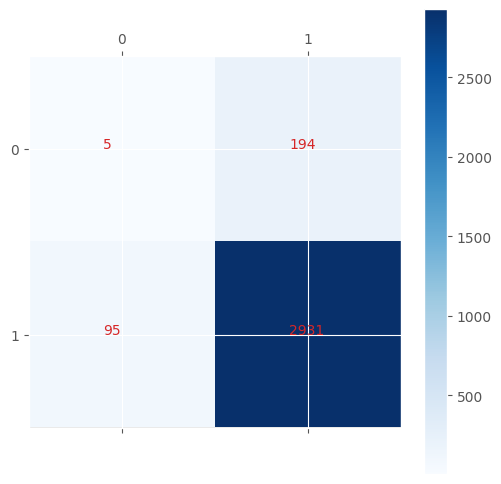

In [114]:
#Visualization for our XGBoost model confusion matrix 
plot_confusion_matrix(y_test3, prediction_xgb3)

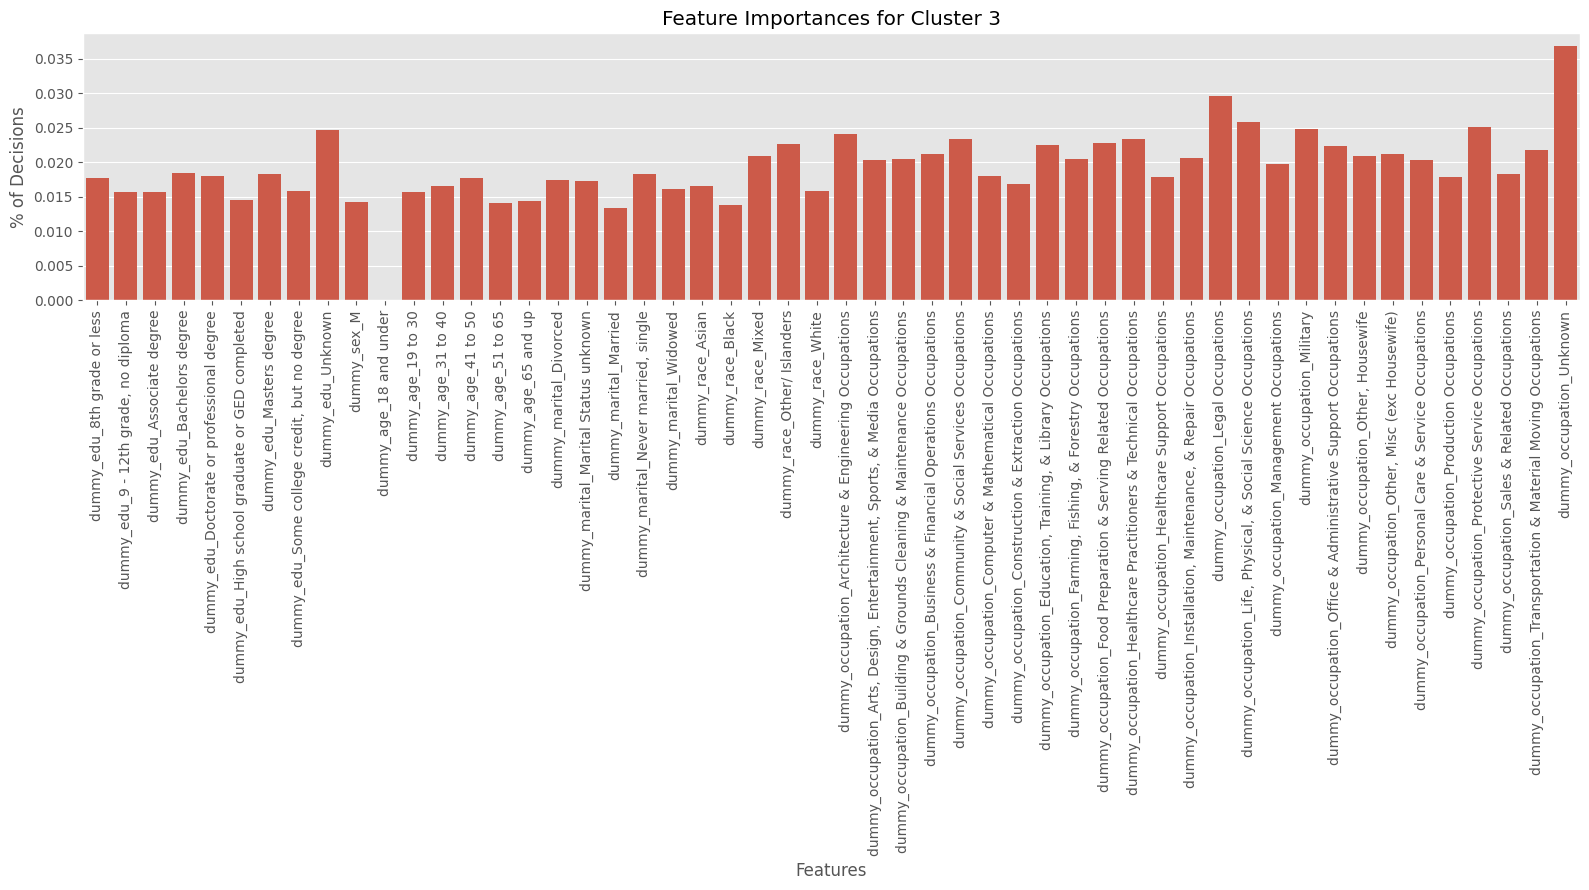

In [115]:
clus3_features = xgb3.feature_importances_

feature_importance(x_train3, clus3_features, 3)

In [116]:
#Tablular format of feature importances and the features being used to make decions for our XGBoost decision tree model
clus3_feature_importances_table = pd.DataFrame(data = {"Features": x_train3.columns, "Data": clus3_features})
clus3_feature_importances_table[clus3_feature_importances_table["Data"] > 0]

,Features,Data
0,dummy_edu_8th grade or less,0.017669
1,"dummy_edu_9 - 12th grade, no diploma",0.015671
2,dummy_edu_Associate degree,0.015745
3,dummy_edu_Bachelors degree,0.018379
4,dummy_edu_Doctorate or professional degree,0.018032
5,dummy_edu_High school graduate or GED completed,0.014545
6,dummy_edu_Masters degree,0.018274
7,"dummy_edu_Some college credit, but no degree",0.015832
8,dummy_edu_Unknown,0.024710
9,dummy_sex_M,0.014248


In [117]:
clus3_top_5 = clus3_feature_importances_table.sort_values(by='Data', ascending=False).head(5)
clus3_top_5

,Features,Data
51,dummy_occupation_Unknown,0.036812
39,dummy_occupation_Legal Occupations,0.029639
40,"dummy_occupation_Life, Physical, & Social Scie...",0.025767
48,dummy_occupation_Protective Service Occupations,0.025118
42,dummy_occupation_Military,0.024869


# Cluster 4: XGBoost/ Oversample 20%/ Tuned

In [118]:
cluster_4 = cluster_4.drop('Clusters', axis=1)
cluster_4.head()

,Education,Sex,AgeCategory,Marital Status,Race,Occupation,Death
0,High school graduate or GED completed,M,19 to 30,"Never married, single",Other/ Islanders,"Farming, Fishing, & Forestry Occupations",Accidental Drug Poisoning
1,High school graduate or GED completed,M,19 to 30,"Never married, single",White,"Farming, Fishing, & Forestry Occupations",Accidental Drug Poisoning
2,Bachelors degree,M,19 to 30,"Never married, single",Black,Business & Financial Operations Occupations,Accidental Drug Poisoning
3,"Some college credit, but no degree",M,19 to 30,"Never married, single",White,Healthcare Practitioners & Technical Occupations,Accidental Drug Poisoning
4,"9 - 12th grade, no diploma",M,19 to 30,"Never married, single",Other/ Islanders,"Other, Misc (exc Housewife)",Accidental Drug Poisoning


In [119]:
cluster_4 = pd.get_dummies(cluster_4, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_4.head()

,dummy_edu_8th grade or less,"dummy_edu_9 - 12th grade, no diploma",dummy_edu_Associate degree,dummy_edu_Bachelors degree,dummy_edu_Doctorate or professional degree,dummy_edu_High school graduate or GED completed,dummy_edu_Masters degree,"dummy_edu_Some college credit, but no degree",dummy_edu_Unknown,dummy_sex_F,...,"dummy_occupation_Other, Housewife","dummy_occupation_Other, Misc (exc Housewife)",dummy_occupation_Personal Care & Service Occupations,dummy_occupation_Production Occupations,dummy_occupation_Protective Service Occupations,dummy_occupation_Sales & Related Occupations,dummy_occupation_Transportation & Material Moving Occupations,dummy_occupation_Unknown,dummy_death_Accidental Drug Poisoning,dummy_death_Other
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [120]:
# Death and Sex attribute has two values only so we can drop one of them since they are considered redundant. 
#We are predicting Accidental or not, so only 1 column is sufficient. 

cluster_4.drop('dummy_death_Other', axis=1, inplace=True)
cluster_4.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_4.drop('dummy_sex_F', axis=1, inplace=True)

#1 = Accidental, 0 = Other

In [121]:
clus4_train, clus4_test = train_test_split(cluster_4, test_size=0.25, random_state=34)
print(clus4_train.shape)
print(clus4_test.shape)

(11271, 52)
(3758, 52)


In [122]:
print(clus4_train["Death"].count())
print(clus4_train["Death"].value_counts(normalize = True))
clus4_train["Death"].value_counts()

11271
1    0.948097
0    0.051903
Name: Death, dtype: float64


1    10686
0      585
Name: Death, dtype: int64

In [123]:
num_samples_other_deaths_4 = determine_samples(len(clus4_train), 585, 0.2)
print("Other Deaths oversample samples to add in Cluster 4: ", num_samples_other_deaths_4)

Other Deaths oversample samples to add in Cluster 4:  2086


In [124]:
to_resample_4 = clus4_train.loc[clus4_train['Death'] == 0]

In [125]:
our_resample_4 = to_resample_4.sample(n = 2086 , replace = True)
clus4_train_rebal = pd.concat([clus4_train, our_resample_4])

In [126]:
clus4_train_rebal['Death'].value_counts()

1    10686
0     2671
Name: Death, dtype: int64

In [127]:
x_train4 = clus4_train_rebal.drop('Death', axis=1)
y_train4 = clus4_train_rebal['Death']

In [128]:
x_test4 = clus4_test.drop('Death', axis=1)
y_test4 = clus4_test['Death']

In [129]:
print(f'Our baseline model for Cluster 4 is {y_train4.value_counts(normalize = True)[1] * 100}% accurate')
print(f'Our baseline model for Cluster 4 based on the testing partition is {y_test4.value_counts(normalize = True)[1] * 100}% accurate')

Our baseline model for Cluster 4 is 80.00299468443512% accurate
Our baseline model for Cluster 4 based on the testing partition is 94.598190526876% accurate


In [130]:
#Using CrossValidation for model selection: 
clus4_models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
                     'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
                     'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
                     'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

clus4_model_cv_score = {}

for name, model in clus4_models_dict.items():
    score4 = cross_val_score(model, x_train4, y_train4, cv=kfold)
    clus4_model_cv_score[name] = score4.mean()

print(f'Model Scores: {clus4_model_cv_score}')

Model Scores: {'RandomForest': 0.8103633183072058, 'NaiveBayes': 0.7992826706138285, 'XGBoost': 0.7989838861602637, 'Decision Tree': 0.8004804996748076}


In [99]:
#Parameter tuning:
clus4_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5, 7]
}

grid4 = GridSearchCV(XGBClassifier(), param_grid = clus4_params, cv = kfold, n_jobs = -1, verbose = 1)
grid4.fit(x_train4, y_train4)

print("Best Parameters found for Cluster 4: ", grid4.best_params_)
print("Best Accuracy through grid search for Cluster 4: %.3f"%grid4.best_score_)

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits
Best Parameters found for Cluster 4:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.8}
Best Accuracy through grid search for Cluster 4: 0.806


In [131]:
#BEST SCORE:
xgb4 = XGBClassifier(colsample_bytree = 0.9, learning_rate = 0.1, max_depth = 7, min_child_weight = 1,
                     n_estimators = 400, subsample = 0.8, random_state=34).fit(x_train4, y_train4)

xgb4_score = cross_val_score(xgb4, x_train4, y_train4, cv=kfold)

In [132]:
print(f"Our XGBoost with the best optimized parameters on the Testing set for Cluster 4 is: {xgb4.score(x_test4, y_test4) * 100}% accurate")
print(f"Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 4 is: {xgb4_score.mean() * 100}% accurate")

Our XGBoost with the best optimized parameters on the Testing set for Cluster 4 is: 93.2410856838744% accurate
Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 4 is: 80.96896656125949% accurate


In [133]:
prediction_xgb4 = xgb4.predict(x_test4)

print("Classification Report for Cluster 4:")
print(classification_report(y_test4, prediction_xgb4))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test4, prediction_xgb4))
print("============")
print("Accuracy Score: ", accuracy_score(prediction_xgb4, y_test4))
print("==============")

test4_predictions_proba = xgb4.predict_proba(x_test4)
log_4 = log_loss(y_test4, test4_predictions_proba)
print("Log Loss: {:.4}".format(log_4))
print("===============")

Classification Report for Cluster 4:
              precision    recall  f1-score   support

           0       0.05      0.01      0.02       203
           1       0.95      0.98      0.96      3555

    accuracy                           0.93      3758
   macro avg       0.50      0.50      0.49      3758
weighted avg       0.90      0.93      0.91      3758

Confusion Matrix
[[   3  200]
 [  54 3501]]
Accuracy Score:  0.932410856838744
Log Loss: 0.2974


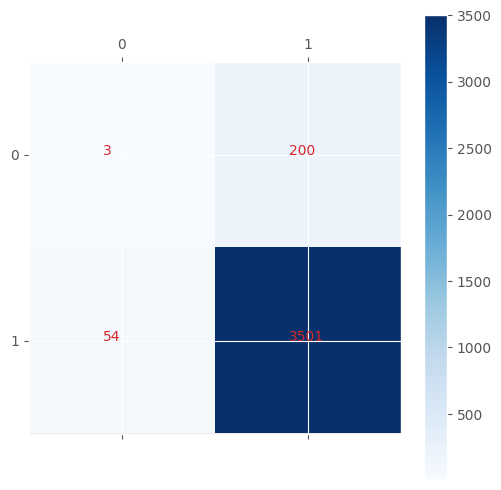

In [134]:
#Visualization for our XGBoost model confusion matrix 
plot_confusion_matrix(y_test4, prediction_xgb4)

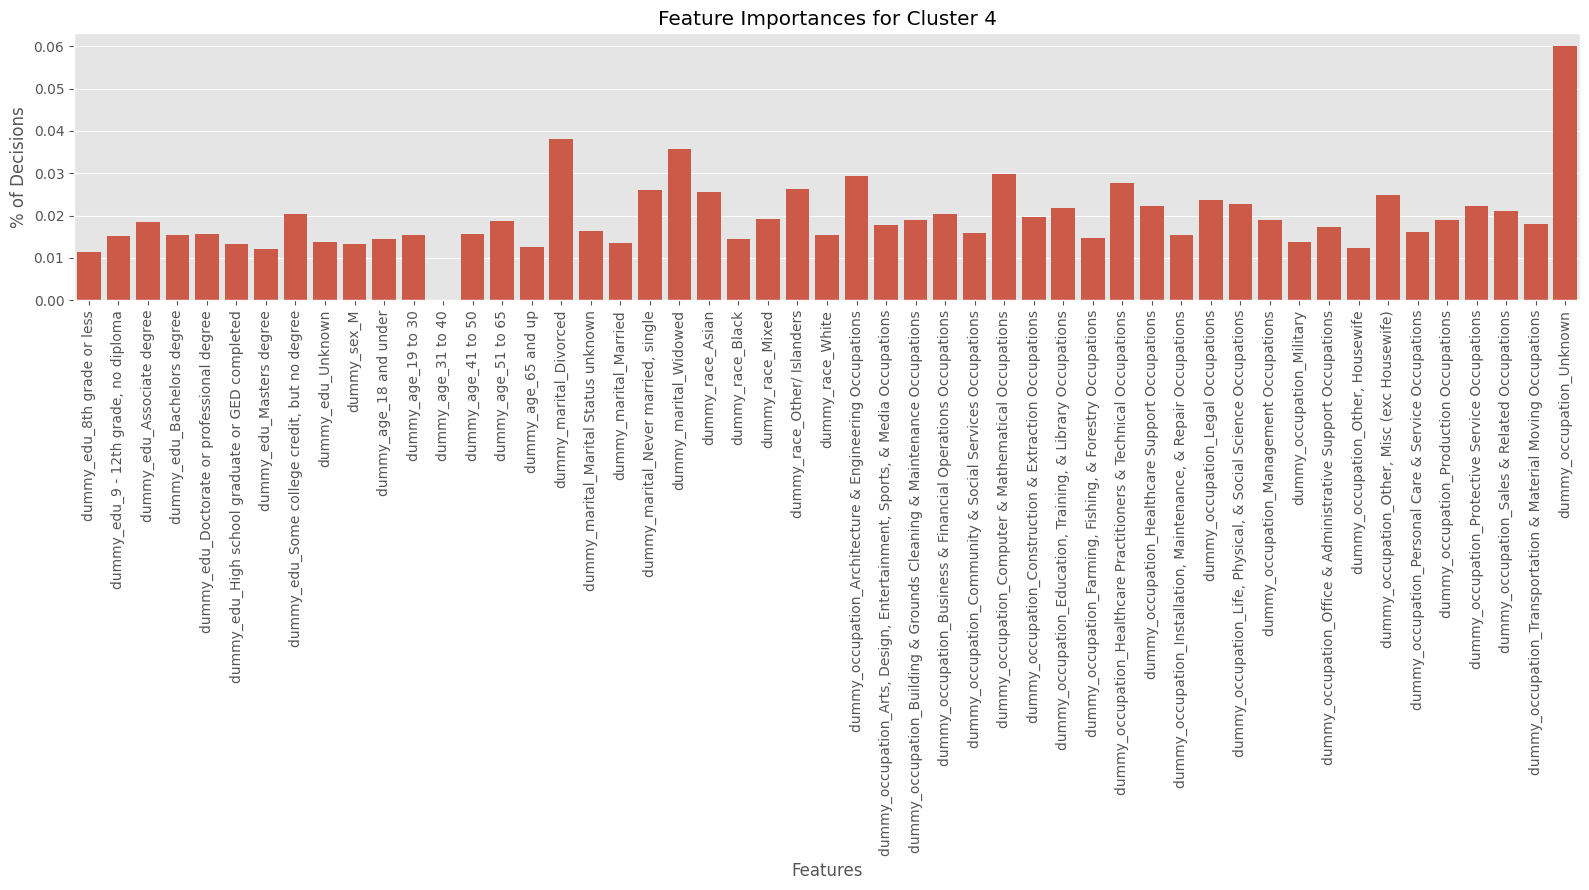

In [135]:
clus4_features = xgb4.feature_importances_

feature_importance(x_train4, clus4_features, 4)

In [136]:
#Tablular format of feature importances and the features being used to make decions for our XGBoost decision tree model
clus4_feature_importances_table = pd.DataFrame(data = {"Features": x_train4.columns, "Data": clus4_features})
clus4_feature_importances_table[clus4_feature_importances_table["Data"] > 0]

,Features,Data
0,dummy_edu_8th grade or less,0.011322
1,"dummy_edu_9 - 12th grade, no diploma",0.015271
2,dummy_edu_Associate degree,0.018453
3,dummy_edu_Bachelors degree,0.015468
4,dummy_edu_Doctorate or professional degree,0.015690
5,dummy_edu_High school graduate or GED completed,0.013325
6,dummy_edu_Masters degree,0.012203
7,"dummy_edu_Some college credit, but no degree",0.020259
8,dummy_edu_Unknown,0.013790
9,dummy_sex_M,0.013283


In [137]:
clus4_top_5 = clus4_feature_importances_table.sort_values(by='Data', ascending=False).head(5)
clus4_top_5

,Features,Data
50,dummy_occupation_Unknown,0.060039
16,dummy_marital_Divorced,0.038142
20,dummy_marital_Widowed,0.035713
31,dummy_occupation_Computer & Mathematical Occup...,0.029861
26,dummy_occupation_Architecture & Engineering Oc...,0.029266
